In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
import sys
import seaborn as sns


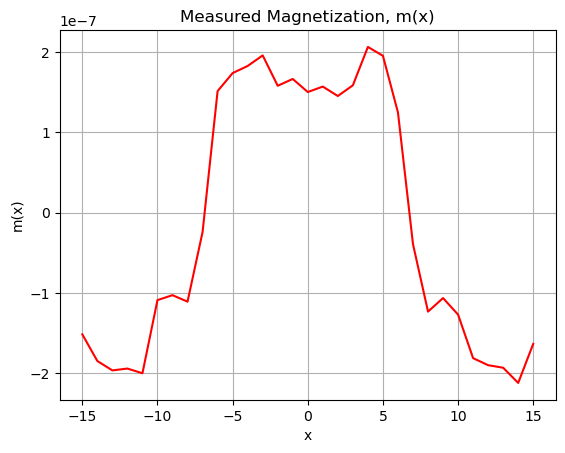

In [2]:
# Specify the path to your text file
file_path = '/Users/odysseaslazaridis/Documents/dataM.txt'

# Read the data from the text file
with open(file_path, 'r') as file:
    lines = file.readlines()

# Process each line to extract values and convert them to a NumPy array
data = [] #cm , nT
for line in lines:
    # Split each line into two values
    values = line.split()
    # Convert the values to float and append to the data list
    data.append([float(values[0]), float(values[1])*10**(-9)])

# Convert the data list to a NumPy array
data = np.array(data)

# # Print the NumPy array
# print(data)

# Plot data
plt.plot(data[:,0], data[:,1], '-r')
plt.title('Measured Magnetization, m(x)')
plt.xlabel('x')
plt.ylabel('m(x)')
plt.grid()


In [4]:
def func(w):
    '''
    I use this function to test if my distribution is close to the theoretical one
    '''
    return 0.125*np.exp(-w*0.125)

In [6]:
def calc_L(M, data):
    
    # take data as input, d
    # covariance-matrix is np.std(d), as we work in 1 dimension ?
    
    M = M.copy()
    d_obs = data[:,1]
    G = calc_G(M,data)
    L = 0.5 *np.exp(-0.5 *( (d_obs -  M[1]@G[:,:31]).T @ np.cov(data) @(d_obs - M[1]@G[:,:31]) )) 
    
    return L


def calc_G(M, d_obs):
# Defining the G matrix
    h = 0.02
    x_coor = np.linspace(-50,50,200)
    x_m = M[1,:]
    mu_0 = 1.256637*10**(-6)   
    G_mat = - mu_0 / (2 * np.pi) * ((x_coor[:, np.newaxis] - x_m[np.newaxis, :])**2 - h**2) / (((x_coor[:, np.newaxis] - x_m[np.newaxis, :])**2 + h**2 )**2)*(0.5)
    return G_mat



In [69]:
def init_system(num_bands,total_width):
    '''
    
    This function initialises M which is 2 x num_bands, first row is defines if it is a boundary or not and 
    the second one has the magnetization
    '''
    M = np.zeros((2,num_bands))
    prob_boundary = 0.125 #the probability to be a boundary is 0.125
    rand_matrix = np.random.rand(num_bands)
    # Set elements of M to 1 where rand_matrix is below prob_boundary
    M[0, rand_matrix < prob_boundary] = 1
    temp = 0
    for i in range(1,num_bands):
        if M[0,i] == 1:
            M[1,temp:i]=np.random.normal(mean_magnetization, std_dev_magnetization,1)
            temp = i
    M[1,temp:num_bands]= np.random.normal(mean_magnetization, std_dev_magnetization,1)*10e-7
    M[0,0] = 1
    #M[0,-1] = 1
    return M

def find_boundary_indices(M):
    # Find indices where M[0, index] == 1
    indices_of_boundaries = np.where(M[0] == 1)[0]
    return indices_of_boundaries
    
# Function to perform perturbation on magnetization
def perturb_magnetization(M):
    
    # Decide whether to perform a stripe magnetization perturbation or a boundary perturbation
    perturbation_type = np.random.choice(["stripe", "boundary"], p=[0.5, 0.5])
    
    if perturbation_type == "stripe":
        indices_of_boundaries = find_boundary_indices(M)
        selected_boundary = np.random.choice(indices_of_boundaries)


        # Randomly choose one of the indices

        if selected_boundary == indices_of_boundaries[-1]:
            next_boundary = 200
        else:
            next_boundary = indices_of_boundaries[np.where(indices_of_boundaries == selected_boundary)[0]+ 1][0]
                
        M[1,selected_boundary: next_boundary] = np.random.normal(mean_magnetization, std_dev_magnetization,1)
        #print("I performed a stripe petrurbation")
    else:
        # Select a random point to potentially add or remove a stripe boundary
        selected_band = np.random.randint(num_bands-1)+1
        
        # Decide whether it is a boundary or not
        make_boundary = np.random.choice([True, False], p=[0.125, 0.875])
        i = 0
        if not make_boundary and M[0,selected_band] == 1: 
            selected_boundary = selected_band
            #In this if statement I know that I am working with a boundary and I will destroy the boundary
            indices_of_boundaries = find_boundary_indices(M)
            if selected_boundary == indices_of_boundaries[-1]:
                next_boundary = 200
            else:
                next_boundary = indices_of_boundaries[np.where(indices_of_boundaries == selected_boundary)[0] + 1][0]
                
            if selected_boundary == 0:
                previous_boundary = 0
            else:
                previous_boundary = indices_of_boundaries[np.where(indices_of_boundaries == selected_boundary)[0] - 1][0]
            
            M[1,previous_boundary:next_boundary] = np.random.normal(mean_magnetization, std_dev_magnetization,1)
            M[0,selected_boundary] = 0 #making it not a boundary
            #print("I performed a boundary petrurbation by destroying one")
            

                
        elif make_boundary and M[0,selected_band] == 0:
            indices_of_boundaries = find_boundary_indices(M)
            
            if selected_band > indices_of_boundaries[-1]:
                next_boundary = 200
            else:
                
                next_boundary = indices_of_boundaries[np.where(indices_of_boundaries > selected_band)[0]][0]
            
            
            if selected_band == 0:
                previous_boundary = 0
            else:
                indices_of_boundaries[np.where(indices_of_boundaries < selected_band)]
                previous_boundary = indices_of_boundaries[np.where(indices_of_boundaries < selected_band)][-1]
            

            M[1,selected_band:next_boundary] = np.random.normal(mean_magnetization, std_dev_magnetization,1)
            M[1,previous_boundary:selected_band] = np.random.normal(mean_magnetization, std_dev_magnetization,1)
            M[0,selected_band] = 1 #making it  a boundary
            #print("I performed a boundary petrurbation by creating one")
            
    return M




In the next cell I calcualte what is the distribution of stripe lengths for the given initialisation for a plane divided in more bands so that I can get a larger variety of lengths to give a nice distribution. I also calculate the average size of a strip in bands. I expect 8

In [71]:
def calc_avg():
    num_bands = 10000
    avg = 0
    samples = 1000
    for j in range(samples):
        M = init_system(num_bands,total_width)
        length = 1000
        hist = np.zeros((length))
        size = 0
        for i in range(num_bands-1):
            if M[1,i] == M[1,i+1]:
                size +=1
            else:
                hist[size]+=1
                size = 0

        hist_norm = hist/np.sum(hist)
        num = np.linspace(1,length,length)

        avg += hist_norm@num/samples
    print("average length is ", avg)
    return hist, M
   
    
hist, M = calc_avg()

average length is  7.997452015862778


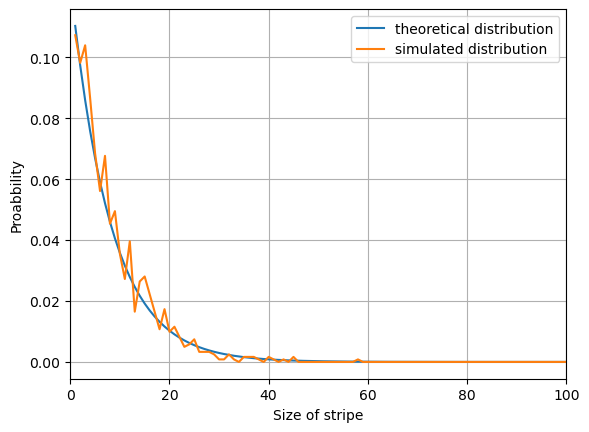

In [72]:
length = 1000
x = np.linspace(1,length,length)
y = func(x)
plt.plot(x,y,label="theoretical distribution")
plt.plot(x,hist/np.sum(hist), label ="simulated distribution")
plt.xlabel("Size of stripe")
plt.ylabel("Proabbility")
plt.grid()
plt.xlim(0,100)
plt.legend()

For a larger number of bands, our distribution seems to very close to the theoretical one.
Instead of larger size I could probably average over multiple runs of the petrurbations

In [74]:
M = init_system(num_bands,total_width)

Text(0, 0.5, 'm(x)')

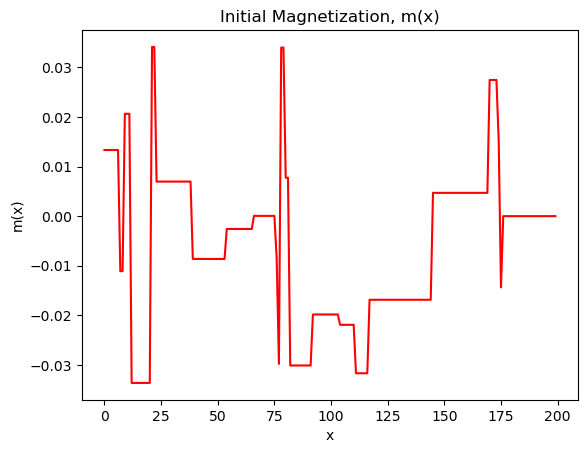

In [75]:
# Plot data
plt.plot(range(len(M[1,:])),M[1,:], '-r')
plt.title('Initial Magnetization, m(x)')
plt.xlabel('x')
plt.ylabel('m(x)')

# 1. Question

The definition of the likelihood function (from the exact theory) is: $L(m) = p_d(g(m))$ (1) and it is a measure of how well the model $m$ fits the observed data. From the definition of an inverse problem we have that $d = g(m)$ (2) .  Because our problem is linear, $d=Gm$ (3) and the function can be rewritten as $L_d(m) = p_d(Gm)$. (4)
Since there is the assumption that the surface dipole magnetization $m$ of each stripe follows a Gaussian probability density distribution, we can take the simplification below: $p_d d=constant \cdot exp (-\frac{1}{2} ({d} - {d_{obs}})^{T} C_{d}^{-1} ({d} - {d_{obs}}))$. (5)
Applying equation (5) to (4)
we have the likelihood function: $ L({m})  = constant \cdot exp (-\frac{1}{2} ({d_{obs}} - {G} {m})^{T} C_{d}^{-1} ({d_{obs}} - {G} {m}))$ .

The distance ${d_{obs}} - {G} {m}$ describes the distance of the observed and the model prediction.

The reason behind why we use the exponential is because we make the assumption that the noise in the observed data follows a Gaussian (normal) distribution.

# 2. Question

Sampling from the prior means that we do not compare our computed data and observed data, thereby generating
samples directly of the theoretical model. In our case this means initializing the model by making a 200 size matrix and assigning in each cell a 1/8 probability of being an edge. Then by using the functuin "perturb_magnetization" we move slightly around the parameter space thus sampling the prior

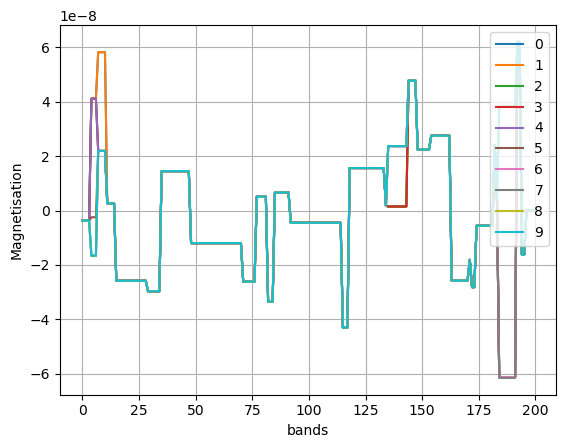

In [77]:
# Constants
num_bands = 200
total_width = 100  # in cm
mean_magnetization = 0  # mean magnetization for each stripe
std_dev_magnetization = 0.025  # standard deviation of magnetization for each stripe


M = init_system(num_bands,total_width) #Initialitation of the system

fig1 = plt.figure()
ax1 = fig1.add_subplot(111)

samples = 10
for i in range(samples):
    
    M_new = perturb_magnetization(M)
    ax1.plot(range(200),M_new[1,:]*10e-7, label=i)
    M = M_new
plt.xlabel('bands')
plt.ylabel('Magnetisation')
plt.grid()
plt.legend()

It is clear to see from this graph that the differences in between consecutive states of the system are
very small meaning that I am making very small steps in the phase space

# Question 3.

In our case the null is chosen to be constant. The null distribution is more targeted and excludes any generic assumptions about the true configuration. Those assumptions are included only in prior distribution.

When choosing our null probability distribution we assume that any configuration of the model parameters is equally probable thus giving us a constant distribution.

# Question 4.
Now it is time to start sampling from the posterior distribution which is given by the product of the likelihood and the prior distribution divided by the null information distribution.



The way this code works is that it first creates the initial guess with the initialisation and after petrurbing the state we use the likelihood function to check if the next state is a better guess. As we have mentioned the null information distribution is constant which means it is not taken into consideration when calculating.
The reason that sampling from the Likelihood transfers directly to sampling from the posteriori is because the configurations that are proposed for evaluation are not completely random, but they are generated from the prior distribution.

After evaluating the likelihood a bunch of times and the value has stabilised we can start sampling from the distribution which will be the posterior. In other words we by comparing out prior distributions with the actuall data we are reforming our distribution in order to resemble the actuall data sa much as possble.

100%|███████████████████████████████████| 30000/30000 [00:07<00:00, 4070.65it/s]


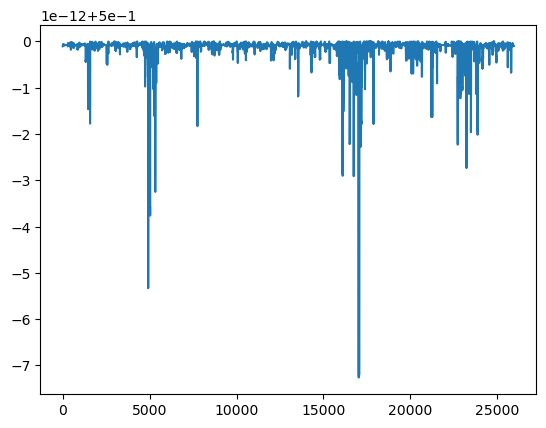

In [28]:
# Constants
num_bands = 200
total_width = 100  # in cm
mean_magnetization = 0  # mean magnetization for each stripe
std_dev_magnetization = 0.025  # standard deviation of magnetization for each stripe
ls = []
burn = 30000
M_old = init_system(num_bands,total_width)

L_old = calc_L(M_old, data)
m_samples = []
for i in tqdm(range(burn)):

    M_new = perturb_magnetization(M_old)
    L_new =  calc_L(M_new, data)
    ratio = L_new/L_old

    if L_new > L_old:
        
        ls.append(L_new)
        M_old = M_new
        L_old = L_new
        m_samples.append(M_new[1,0])
        
    elif np.random.normal(0,1)< L_new/L_old:
        ls.append(L_new)
        M_old = M_new
        L_old = L_new
        m_samples.append(M_new[1,0])
        
        
        
plt.plot(range(len(ls)),ls)

    
    
        
    




As we can see the value of L stabilizes very quickly around 0.5 which doesn't look pretty but I couldn't find what is the reason behind that. The spikes are because there is a probability that a worse value of L will be accepted given by the ratio of the new over the old likelihood.

Lets close our eyes and imagine that it worked and the likelihood looks better. In that case in order to visualise the posteriori distribution I should take the average of different samples of this distribution.

In the next cell I do exactlyh that where I sample 20000 times by petrurbing my system 100 times in between every sample. Theoreticaly here I should get something that looks like the data in the center of my plot as the data are from -15 to 15 cm and my model is from -50 to +50 cm.

In [61]:
samples_2 = 100000
sampling_distance = 50
M_avg = np.zeros((2,num_bands))
for i in tqdm(range(samples_2)):
    for j in range(sampling_distance):
        M_new = perturb_magnetization(M_new)
    M_avg += M_new/samples_2

100%|██████████████████████████████████| 100000/100000 [02:03<00:00, 807.15it/s]


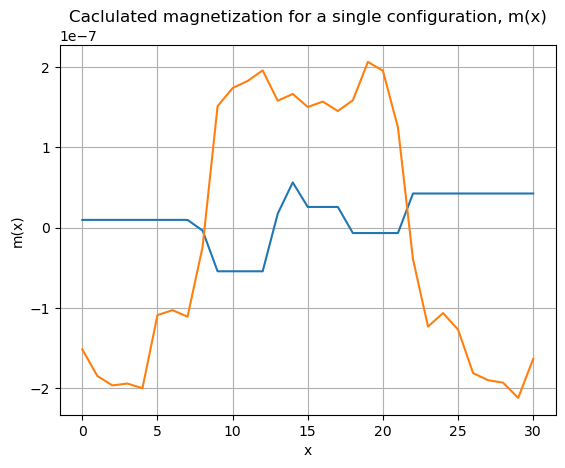

In [67]:
# Plot data
fig2 = plt.figure()
ax1 = fig2.add_subplot(111)
ax1.plot(range(31),M_new[1,85:116])
ax1.plot(range(31), data[:,1])
plt.title('Caclulated magnetization for a single configuration, m(x)')
plt.xlabel('x')
plt.ylabel('m(x)')
plt.grid()

In [ ]:
# Plot data
fig2 = plt.figure()
ax1 = fig2.add_subplot(111)
ax1.plot(range(200),M_avg[1,:])
plt.title('Average magnetization')
plt.xlabel('x')
plt.ylabel('m(x)')
plt.grid()

This is after we have burned the first few thousand petrurbation in order to stabilise the Likelihood or Missfit function

It is clear that the distribution is not going even close to the actual observed data. In an Ideal scenario I would have seen something that resembles my observed data. 

# Question 5.

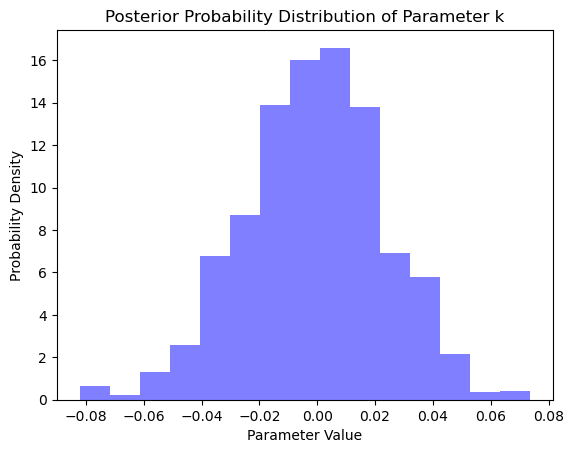

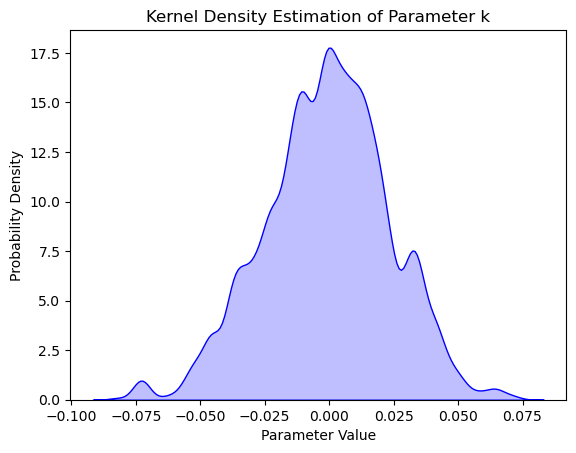

Mean: -0.0008505702393322861
Median: -0.00040416590228696764
Standard Deviation: 0.024100652915226096
95% Confidence Interval: [-0.04883491  0.04264144]


In [48]:
# Histogram Calculation
plt.hist(m_samples, bins=15, density=True, alpha=0.5, color='b')
plt.title('Posterior Probability Distribution of Parameter k')
plt.xlabel('Parameter Value')
plt.ylabel('Probability Density')
plt.show()

# Kernel Density Estimation
sns.kdeplot(m_samples, fill=True, color='b')
plt.title('Kernel Density Estimation of Parameter k')
plt.xlabel('Parameter Value')
plt.ylabel('Probability Density')
plt.show()

# Summary Statistics
mean_value = np.mean(m_samples)
median_value = np.median(m_samples)
std_dev = np.std(m_samples)

# Confidence Intervals
confidence_interval = np.percentile(m_samples, [2.5, 97.5])


# Print summary statistics and confidence interval
print(f"Mean: {mean_value}")
print(f"Median: {median_value}")
print(f"Standard Deviation: {std_dev}")
print(f"95% Confidence Interval: {confidence_interval}")